In [1]:
# %load ../src/goes16_utils.py
# Training: Python and GOES-R Imagery: Script 8 - Functions for download data from AWS
#-----------------------------------------------------------------------------------------------------------
# Required modules
import os                                # Miscellaneous operating system interfaces
import numpy as np                       # Import the Numpy package
import colorsys                          # To make convertion of colormaps
import boto3                             # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config
import math                              # Mathematical functions
from datetime import datetime            # Basic Dates and time types
from osgeo import osr                    # Python bindings for GDAL
from osgeo import gdal                   # Python bindings for GDAL

#-----------------------------------------------------------------------------------------------------------
def loadCPT(path):

    try:
        f = open(path)
    except:
        print ("File ", path, "not found")
        return None

    lines = f.readlines()

    f.close()

    x = np.array([])
    r = np.array([])
    g = np.array([])
    b = np.array([])

    colorModel = 'RGB'

    for l in lines:
        ls = l.split()
        if l[0] == '#':
            if ls[-1] == 'HSV':
                colorModel = 'HSV'
                continue
            else:
                continue
        if ls[0] == 'B' or ls[0] == 'F' or ls[0] == 'N':
            pass
        else:
            x=np.append(x,float(ls[0]))
            r=np.append(r,float(ls[1]))
            g=np.append(g,float(ls[2]))
            b=np.append(b,float(ls[3]))
            xtemp = float(ls[4])
            rtemp = float(ls[5])
            gtemp = float(ls[6])
            btemp = float(ls[7])

        x=np.append(x,xtemp)
        r=np.append(r,rtemp)
        g=np.append(g,gtemp)
        b=np.append(b,btemp)

    if colorModel == 'HSV':
        for i in range(r.shape[0]):
            rr, gg, bb = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
        r[i] = rr ; g[i] = gg ; b[i] = bb

    if colorModel == 'RGB':
        r = r/255.0
        g = g/255.0
        b = b/255.0

    xNorm = (x - x[0])/(x[-1] - x[0])

    red   = []
    blue  = []
    green = []

    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    colorDict = {'red': red, 'green': green, 'blue': blue}

    return colorDict
#-----------------------------------------------------------------------------------------------------------
def download_CMI(yyyymmddhhmn, band, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'
  product_name = 'ABI-L2-CMIPF'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6C{int(band):02.0f}_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Band-{band}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

#-----------------------------------------------------------------------------------------------------------
def download_PROD(yyyymmddhhmn, product_name, path_dest):

  # os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  # s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Product: {product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # print(f'File name: {file_name}')

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        # print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
def download_GLM(yyyymmddhhmnss, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%H')
  min = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%M')
  seg = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%S')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  product_name = "GLM-L2-LCFA"
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}_G16_s{year}{day_of_year}{hour}{min}{seg}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmnss}, Product-{product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
# Functions to convert lat / lon extent to array indices
def geo2grid(lat, lon, nc):

    # Apply scale and offset
    xscale, xoffset = nc.variables['x'].scale_factor, nc.variables['x'].add_offset
    yscale, yoffset = nc.variables['y'].scale_factor, nc.variables['y'].add_offset

    x, y = latlon2xy(lat, lon)
    col = (x - xoffset)/xscale
    lin = (y - yoffset)/yscale
    return int(lin), int(col)

def latlon2xy(lat, lon):
    # goes_imagery_projection:semi_major_axis
    req = 6378137 # meters
    #  goes_imagery_projection:inverse_flattening
    invf = 298.257222096
    # goes_imagery_projection:semi_minor_axis
    rpol = 6356752.31414 # meters
    e = 0.0818191910435
    # goes_imagery_projection:perspective_point_height + goes_imagery_projection:semi_major_axis
    H = 42164160 # meters
    # goes_imagery_projection: longitude_of_projection_origin
    lambda0 = -1.308996939

    # Convert to radians
    latRad = lat * (math.pi/180)
    lonRad = lon * (math.pi/180)

    # (1) geocentric latitude
    Phi_c = math.atan(((rpol * rpol)/(req * req)) * math.tan(latRad))
    # (2) geocentric distance to the point on the ellipsoid
    rc = rpol/(math.sqrt(1 - ((e * e) * (math.cos(Phi_c) * math.cos(Phi_c)))))
    # (3) sx
    sx = H - (rc * math.cos(Phi_c) * math.cos(lonRad - lambda0))
    # (4) sy
    sy = -rc * math.cos(Phi_c) * math.sin(lonRad - lambda0)
    # (5)
    sz = rc * math.sin(Phi_c)

    # x,y
    x = math.asin((-sy)/math.sqrt((sx*sx) + (sy*sy) + (sz*sz)))
    y = math.atan(sz/sx)

    return x, y

# Function to convert lat / lon extent to GOES-16 extents
def convertExtent2GOESProjection(extent):
    # GOES-16 viewing point (satellite position) height above the earth
    GOES16_HEIGHT = 35786023.0
    # GOES-16 longitude position
    GOES16_LONGITUDE = -75.0

    a, b = latlon2xy(extent[1], extent[0])
    c, d = latlon2xy(extent[3], extent[2])
    return (a * GOES16_HEIGHT, c * GOES16_HEIGHT, b * GOES16_HEIGHT, d * GOES16_HEIGHT)

#-----------------------------------------------------------------------------------------------------------
# Function to reproject the data
def reproject(file_name, ncfile, array, extent, undef):

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(ncfile.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = ncfile.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', array.shape[0], array.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(array)

    # Define the parameters of the output file
    kwargs = {'format': 'netCDF', \
            'srcSRS': source_prj, \
            'dstSRS': target_prj, \
            'outputBounds': (extent[0], extent[3], extent[2], extent[1]), \
            'outputBoundsSRS': target_prj, \
            'outputType': gdal.GDT_Float32, \
            'srcNodata': undef, \
            'dstNodata': 'nan', \
            'resampleAlg': gdal.GRA_NearestNeighbour}

    # Write the reprojected file on disk
    gdal.Warp(file_name, raw, **kwargs)

In [2]:
path = '../data/goes16/'
file_name = 'OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.nc'

# Region of Interest - Rio de Janeiro municipality
extent = [-43.890602827150, -23.1339033365138, -43.0483514573222, -22.64972474827293]

## NetCDF to Pickle

In [3]:
from netCDF4 import Dataset              # Read / Write NetCDF4 files
import matplotlib.pyplot as plt          # Plotting library
from datetime import datetime            # Basic Dates and time types
import cartopy, cartopy.crs as ccrs      # Plot maps
import os                                # Miscellaneous operating system interfaces
import pickle

def netcdf2pickle(path, file_name):
    #-----------------------------------------------------------------------------------------------------------
    # Open the GOES-R image
    full_disk_ds = Dataset(path+file_name)

    print(full_disk_ds)

    # Convert lat/lon to grid-coordinates
    lly, llx = geo2grid(extent[1], extent[0], full_disk_ds)
    ury, urx = geo2grid(extent[3], extent[2], full_disk_ds)

    dict_indices = {}
    for instability_index_name in ['CAPE', 'LI', 'TT', 'SI', 'KI']:
        # Get the pixel values
        data = full_disk_ds.variables[instability_index_name][ury:lly, llx:urx]
        dict_indices[instability_index_name] = data

    data = full_disk_ds.variables['DQF_Overall'][ury:lly, llx:urx]
    dict_indices['DQF_Overall'] = data

    print(f'Shape of sliced data: {data.shape}')
    
    # create a file to store the pickled data
    temp = os.path.splitext(file_name)  # given '/home/user/somefile.nc',  returns ('/home/user/somefile', '.nc')
    pkl_file_name = f'{temp[0]}.pkl'
    pkl_file = open(pkl_file_name, 'wb')

    # Extract date
    # date = (datetime.strptime(file.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))
    # print(date)

    print(f'Created pickle file: {pkl_file_name}')

    # dump information to that file
    pickle.dump(dict_indices, pkl_file)

    # close the file
    pkl_file.close()

In [4]:
netcdf2pickle(path, file_name)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 10km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.nc
    iso_series_metadata_id: 158fae30-affd-11e1-afa6-0800200c9a66
    title: ABI L2 Derived Stability Indices
    summary: The Derived Stability Indices product consists of the atmosphe

## Pickle to PNG

In [5]:
import os

def min_max_normalize_masked_array(masked_array: np.ma.MaskedArray):
    # Ensure the input is a MaskedArray
    if not isinstance(masked_array, np.ma.MaskedArray):
        raise ValueError("Input must be a numpy.ma.MaskedArray")

    # Calculate the min and max values ignoring the masked elements
    min_val = masked_array.min()
    max_val = masked_array.max()

    # Avoid division by zero in case max_val equals min_val
    if max_val == min_val:
        return np.ma.masked_array(np.zeros_like(masked_array), mask=masked_array.mask)

    # Apply the min-max normalization
    normalized_array = (masked_array - min_val) / (max_val - min_val)

    return normalized_array

def split_filename(full_filename):
    # Extract the directory path and the filename with extension
    dir_path, filename_with_ext = os.path.split(full_filename)
    
    # Extract the base name and the extension
    base_name, file_ext = os.path.splitext(filename_with_ext)
    
    return (dir_path, base_name, file_ext)

def pkl2png(file_name: str, product_name: str, extent: list, output_folder: str, show_image: bool = False):
    # open a file, where you stored the pickled data
    file = open(file_name, 'rb')

    dsif_data = pickle.load(file)

    # close the file
    file.close()

    data = dsif_data[product_name]
    
    #-----------------------------------------------------------------------------------------------------------
    # Compute data-extent in GOES projection-coordinates
    img_extent = convertExtent2GOESProjection(extent)
    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(10,10))

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

    # Define the color scale based on the channel
    colormap = "jet" # White to black for IR channels
    
    data = min_max_normalize_masked_array(data)

    # Plot the image
    img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

    # Add a colorbar
    plt.colorbar(img, label='CAPE', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # Extract the date
    # date = (datetime.strptime(file.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

    # Add a title
    plt.title(f'GOES-16 {product_name}', fontweight='bold', fontsize=10, loc='left')
    plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
    #-----------------------------------------------------------------------------------------------------------
    # Save the image
    dir_path, base_name, file_ext = split_filename(file_name)
    png_file_name = f'{output_folder}/{base_name}.png'
    print()
    plt.savefig(png_file_name, bbox_inches='tight', pad_inches=0, dpi=300)
    print(f'Created pickle file: {png_file_name}')

    if show_image:
        # Show the image
        plt.show()

    plt.close()

In [6]:
# import os

# def split_filename(full_filename):
#     # Extract the directory path and the filename with extension
#     dir_path, filename_with_ext = os.path.split(full_filename)
    
#     # Extract the base name and the extension
#     base_name, file_ext = os.path.splitext(filename_with_ext)
    
#     return (dir_path, base_name, file_ext)

# # Example usage
# full_filename = '/home/user/somefile.pkl'
# components = split_filename(full_filename)
# print(components)  # Output: ('/home/user', 'somefile', '.pkl')


FileNotFoundError: [Errno 2] No such file or directory: '../data/goes16/dsif_data/png/OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.png'

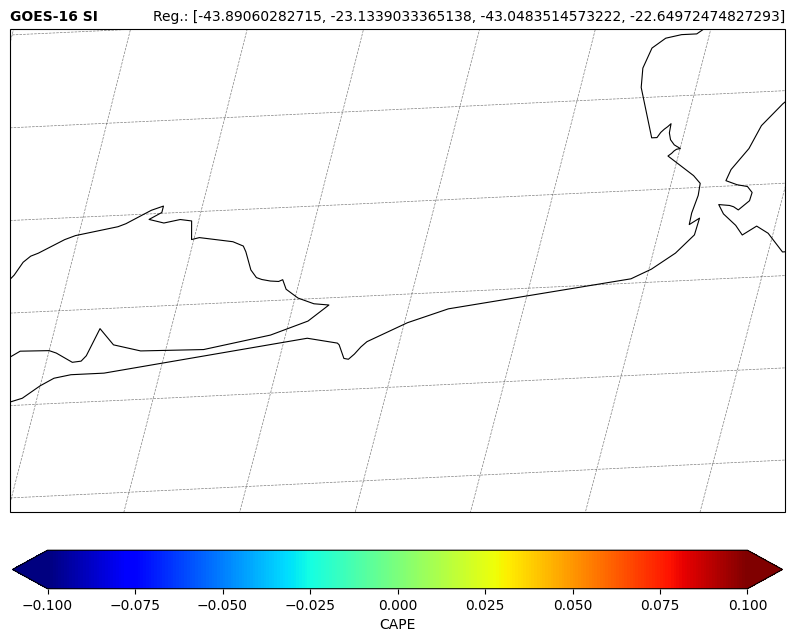

In [7]:
# filename = '../data/goes16/dsif_data/202401010050.pkl'
filename = 'OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.pkl'
output_folder = '../data/goes16/dsif_data/png'
pkl2png(filename, 'SI', extent, output_folder, show_image = True)

# Animation code

In [ ]:
# conda install -c conda-forge ffmpeg

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import pickle
from datetime import datetime, timedelta

def generate_timestamps(initial_timestamp, final_timestamp, interval_in_minutes = 10):
    # Parse the input timestamps to datetime objects
    initial_dt = datetime.strptime(initial_timestamp, '%Y%m%d%H%M')
    final_dt = datetime.strptime(final_timestamp, '%Y%m%d%H%M')

    # Generate timestamps in 10-minute intervals
    timestamps = []
    current_dt = initial_dt

    while current_dt <= final_dt:
        timestamps.append(current_dt.strftime('%Y%m%d%H%M'))
        current_dt += timedelta(minutes=interval_in_minutes)

    return timestamps

def get_frame(data, extent):
    #-----------------------------------------------------------------------------------------------------------
    # Compute data-extent in GOES projection-coordinates
    img_extent = convertExtent2GOESProjection(extent)
    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    # plt.figure(figsize=(10,10))

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

    # Define the color scale based on the channel
    colormap = "jet" # White to black for IR channels

    # Plot the image
    img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap, animated = True)

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

    # Add a colorbar
    # plt.colorbar(img, label='CAPE', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # plt.close()
    
    return img
    return plt.imgshow()

def gen_animation(initial_timestamp: str, final_timestamp: str, input_folder: str, product_name: str, extent: list, out_file_name: str):
    def update_frame(frame_number, img, images):
        """Update the image for each frame of the animation."""
        img.set_array(images[frame_number])
        return img,
    
    # fig = plt.figure()

    i_timestamp = int(initial_timestamp)
    f_timestamp = int(final_timestamp)

    assert i_timestamp <= f_timestamp
    
    timestamps = generate_timestamps(initial_timestamp, final_timestamp, interval_in_minutes = 10)

    # images is a list of artists to draw at each frame
    images = []
    for timestamp in timestamps:
        # print(f'Current timestamp: {timestamp}')

        filename = f'{input_folder}/{timestamp}.pkl'

        # open a file containing the pickled data
        file = open(filename, 'rb')

        pickled_data = pickle.load(file)

        # close the file
        file.close()

        data = pickled_data[product_name]

        images += [data]

    num_images = len(images)
    print(num_images)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

    # See https://stackoverflow.com/questions/67855367/remove-axis-from-animation-artistanimation-python
    # ax = fig.add_subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.axis('off')

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

    img = ax.imshow(images[0], interpolation='none')

    # Create the animation
    ani = animation.FuncAnimation(fig, update_frame, frames=num_images, fargs=(img, images), blit=True)

    # Save the animation
    ani.save(out_file_name)
    print(f'Created MP4 file: {out_file_name}')

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# def generate_random_images(num_images, image_shape):
#     """Generate a list of random images."""
#     return [np.random.rand(*image_shape) for _ in range(num_images)]

# def update_frame(frame_number, img, images):
#     """Update the image for each frame of the animation."""
#     img.set_array(images[frame_number])
#     return img,

# # Parameters
# num_images = 10
# image_shape = (10, 10)  # Shape of the random images

# # Generate random images
# images = generate_random_images(num_images, image_shape)

# # Create a figure and axis
# fig, ax = plt.subplots()
# print(type(images), type(images[0]))
# img = ax.imshow(images[0], interpolation='none')

# # Create the animation
# ani = animation.FuncAnimation(fig, update_frame, frames=num_images, fargs=(img, images), blit=True)

# # Save the animation as an MP4 file
# ani.save('random_images_animation.mp4', writer='ffmpeg', fps=1)

# # Display the animation in the notebook (optional)
# # plt.show()

In [ ]:
# N.B.: timestamp format is YYYYMMDDHHMM
# plot_anim(initial_timestamp = '202401130000', final_timestamp = '202401132350', input_folder = '../data/goes16/dsif_data')
gen_animation(initial_timestamp = '202401130000', 
                final_timestamp = '202401132350', 
                input_folder = '../data/goes16/dsif_data', 
                product_name = 'CAPE', 
                extent = extent, 
                out_file_name = '../data/goes16/CAPE_2024_01_01.mp4')

In [ ]:
# import numpy as np

# def min_max_normalize_masked_array(masked_array):
#     # Ensure the input is a MaskedArray
#     if not isinstance(masked_array, np.ma.MaskedArray):
#         raise ValueError("Input must be a numpy.ma.MaskedArray")

#     # Calculate the min and max values ignoring the masked elements
#     min_val = masked_array.min()
#     max_val = masked_array.max()

#     # Avoid division by zero in case max_val equals min_val
#     if max_val == min_val:
#         return np.ma.masked_array(np.zeros_like(masked_array), mask=masked_array.mask)

#     # Apply the min-max normalization
#     normalized_array = (masked_array - min_val) / (max_val - min_val)

#     return normalized_array

# # Example usage
# data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# mask = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
# masked_array = np.ma.masked_array(data, mask=mask)

# normalized_masked_array = min_max_normalize_masked_array(masked_array)
# print(normalized_masked_array)


In [ ]:
import pandas as pd
df = pd.read_parquet('../ABI-L2-DSIF_2024-01-13_to_2024-01-13.parquet')
filtered_df = df[~df['CAPE'].isnull()]
filtered_df.head()

In [ ]:
import pandas as pd
df = pd.read_parquet('../ABI-L2-TPWF_2024-01-13_to_2024-01-13.parquet')
filtered_df = df[~df['TPW'].isnull()]
filtered_df.head()

## Reprojection with GDAL

File ../data/goes16/curso_cptec/Samples/OR_ABI-L2-DSIF-M6_G16_s20240132300205_e20240132309513_c20240132311347.nc exists


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


type(ds): <class 'numpy.ndarray'>
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7fb48d0f8c90> >, None, None)
type(raw): <class 'osgeo.gdal.Dataset'>
Station ID: A627, Lat/Lon: (-22.86749999, -43.10194444), Grid cell: (1, 6), Pixel value: 5000.38134765625
Station ID: A652, Lat/Lon: (-22.98833333, -43.19055555), Grid cell: (2, 5), Pixel value: 5000.38134765625
Station ID: A636, Lat/Lon: (-22.93999999, -43.40277777), Grid cell: (2, 4), Pixel value: 5000.38134765625
Station ID: A621, Lat/Lon: (-22.86138888, -43.41138888), Grid cell: (1, 3), Pixel value: 5000.38134765625
Station ID: A602, Lat/Lon: (-23.05027777, -43.59555555), Grid cell: (3, 2), Pixel value: 5000.38134765625
Station ID: A601, Lat/Lon: (-22.75777777, -43.68472221), Grid cell: (0, 1), Pixel value: 5000.38134765625
Station ID: vidigal, Lat/Lon: (-22.9925, -43.2331), Grid cell: (2, 5), Pixel value: 5000.38134765625
Station ID: iraja, Lat/Lon: (-22.8269, -43.3369), Grid cell: (1, 4), 

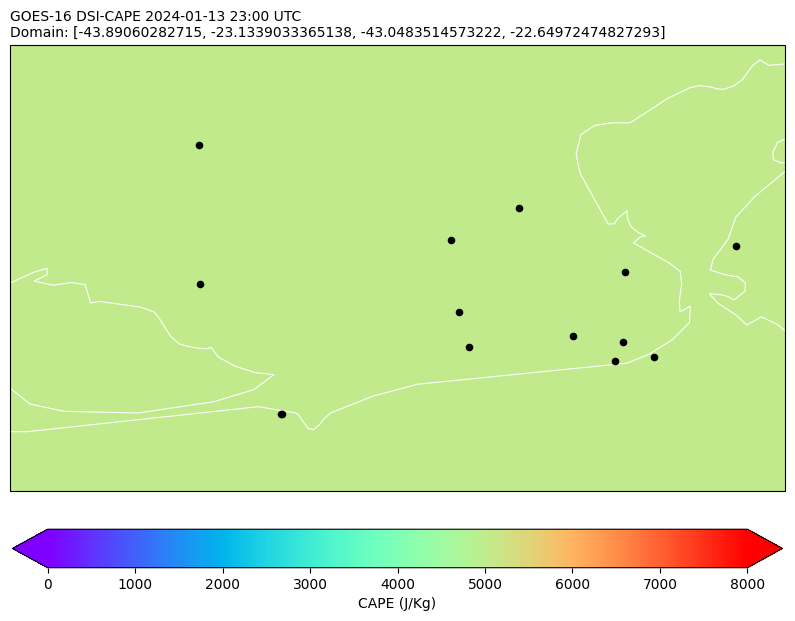

In [8]:
# Training: Python and GOES-R Imagery: Script 14 - Reprojection with GDAL
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python
# from utilities import download_CMI              # Our function for download

import pandas as pd

# Check if the point is inside the bounding box
def is_point_in_bbox(point_lat, point_lon, extent):
    min_lon, min_lat, max_lon, max_lat = extent
    return min_lon <= point_lon <= max_lon and min_lat <= point_lat <= max_lat

#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "../data/goes16/curso_cptec/Samples"
output = "../data/goes16/curso_cptec/Output"

# Desired extent
# extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Max lon, Min lat, Max lat
extent = [-43.890602827150, -23.1339033365138, -43.0483514573222, -22.64972474827293]

# Datetime to process
yyyymmddhhmn = '202401132300'
# yyyymmddhhmn = '202406131800'
# yyyymmddhhmn = '202102181800'
# yyyymmddhhmn = '202012161300'

product_name = 'ABI-L2-DSIF'

# Download the file
file_name = download_PROD(yyyymmddhhmn, product_name, path_dest=input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CAPE'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_name}.nc:' + var)

# Data Quality Flag (DQF)
dqf = gdal.Open(f'NETCDF:{input}/{file_name}.nc:DQF_Overall')

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)
ds_dqf = dqf.ReadAsArray(0, 0, dqf.RasterXSize, dqf.RasterYSize).astype(float)

# Apply the scale and offset
ds = (ds * scale + offset)

# Apply NaN's where the quality flag is greater than 1
# ds[ds_dqf > 1] = np.nan

print('type(ds):', type(ds))

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName('MEM')
raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file  
options = gdal.WarpOptions(format = 'netCDF', 
          srcSRS = source_prj, 
          dstSRS = target_prj,
          outputBounds = (extent[0], extent[3], extent[2], extent[1]), 
          outputBoundsSRS = target_prj, 
          outputType = gdal.GDT_Float32, 
          srcNodata = undef, 
          dstNodata = 'nan', 
        #   xRes = 0.01, 
        #   yRes = 0.01, 
          resampleAlg = gdal.GRA_NearestNeighbour)

print(options)

print('type(raw):', type(raw))

# Write the reprojected file on disk
filename_reprojected = f'{output}/{file_name}_ret.nc'
gdal.Warp(filename_reprojected, raw, options=options)
#-----------------------------------------------------------------------------------------------------------
# Open the reprojected GOES-R image
file = Dataset(filename_reprojected)

sat_data = gdal.Open(f'{filename_reprojected}')
# Read number of cols and rows
ncol = sat_data.RasterXSize
nrow = sat_data.RasterYSize
# Load the data
sat_array = sat_data.ReadAsArray(0, 0, ncol, nrow).astype(float)
# Get geotransform
transform = sat_data.GetGeoTransform()

# Get the pixel values
data = file.variables['Band1'][:]
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
colormap = plt.get_cmap('rainbow').resampled(240)

# Plot the image
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap, vmin=0, vmax=8000)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
plt.colorbar(img, label='CAPE (J/Kg)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 DSI-CAPE ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC' + '\nDomain: ' + str(extent), fontsize=10, loc='left')
#-----------------------------------------------------------------------------------------------------------
# Save the image
# plt.savefig(f'{output}/Image_14.png', bbox_inches='tight', pad_inches=0, dpi=300)

stations_filename = "../data/ws/WeatherStations.csv"
df_stations = pd.read_csv(stations_filename)

for index, row in df_stations.iterrows():
    station_id = row['STATION_ID']

    # if not station_id.startswith('A652'):
    #   continue

    point_lat = row['VL_LATITUDE']
    point_lon = row['VL_LONGITUDE']
    if is_point_in_bbox(point_lat, point_lon, extent):
      # Plot the point
      x = int((point_lon - transform[0]) / transform[1])
      y = int((transform[3] - point_lat) / -transform[5])
      pixel_value = sat_array[y,x]
      print(f"Station ID: {station_id}, Lat/Lon: ({point_lat}, {point_lon}), Grid cell: ({y}, {x}), Pixel value: {pixel_value}")
      ax.scatter(point_lon, point_lat, color='black', s=20, edgecolor='black', transform=ccrs.PlateCarree(), zorder=5)

# Show the image
plt.show()

In [ ]:
ds.shape

In [ ]:
print(data[0,0])
print(data[0,1])
print(data[0,2])
print(data[0,3])
print(data[0,4])
print(data[0,5])
print(data[0,6])
print(' ~ ')
print(data[1,0])
print(data[1,1])
print(data[1,2])
print(data[1,3])
print(data[1,4])
print(data[1,5])
print(data[1,6])


In [ ]:
import os
input_folder_path = '../data/goes16/DSI/'

i = 0

# Use a for loop to unpack the values returned by os.walk
for root, dirs, files in os.walk(input_folder_path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    if i == 10:
        break
    i += 1